Modified from:

[https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm](https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm).


GitHub: https://github.com/bevanyeah/Assignments

Welcome to your assignment this week! 

To better understand adverse attacks againsts AI and how it is possible to fool an AI system, in this assignment, we will look at a Computer Vision use case. 




This assessment creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

# What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

# Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy find how each input pixel contributes to the loss, by using the chain rule, and finding the required gradients. Hence, the gradients are used with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.



# Part 1

So let's try and fool a pretrained model. In this first part, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).


Run the following cell to install all the packages you will need.

In [170]:
# ! pip3 install cython
# ! pip3 install tensornets
# ! pip3 install numpy==1.16.1
# ! pip3 install tensorflow
# ! pip3 install matplotlib

Run the following cell to load the packages you will need.

In [171]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib as mplcn
import matplotlib.pyplot as plt
import tensornets as nets

In [172]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

Device mapping:



Let's define the computation graph.

In [173]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image /  127.5
    image = image - 1.0
    image = image[None, ...]
    return image
def reverse_preprocess(image):
    image = image + 1.0
    image = image / 2.0
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=5)[0]


# Lets's import an image to process.
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_png(image_raw)
input_image = preprocess(image)
reversed_image = reverse_preprocess(input_image)

input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)

# node to load pretrained weights
pretrained_ops = pretrained_model.pretrained()

# decode predicted probabilities to ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions


## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) -by Mirko       [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [174]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

sess.run(pretrained_ops)
preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})

Device mapping:



Let's have a look at the image.

['Labrador_retriever', 'Ibizan_hound', 'Saluki', 'Chesapeake_Bay_retriever', 'Weimaraner']


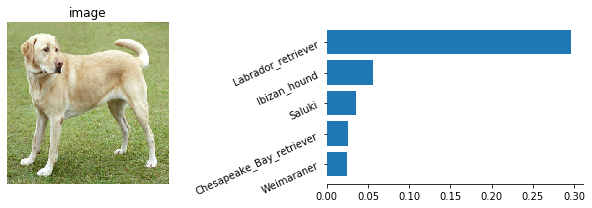

In [175]:
top5 = get_imagenet_label(image_probs[0])
tick_names = [x[1] for x in top5]
print(tick_names)
probs = [x[2] for x in top5]
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(reversed_img[0])
plt.title('image')
ax = plt.gca()
ax.axis('off')

plt.subplot(122)
tick_names = [x[1] for x in reversed(top5)]
probs = [x[2] for x in reversed(top5)]
plt.barh(tick_names, probs)
plt.yticks(rotation=25)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

# Create the adversarial image

## Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

**TASK 1:** Implement `create_adversarial_pattern()`. You will need to carry out 3 steps:

1. Create a loss object using `loss_object` using two arguments: `pretrained_model` and `input_label`.
2. Get the gradients using `tf.gradients` of the `loss`  w.r.t to the `input_image`.
3. Get the sign of the gradients to create the perturbation using `tf.sign`.


In [176]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    ## START YOU CODE HERE (3 lines)
    loss = loss_object(input_label,pretrained_model)
    gradient = tf.gradients(loss,input_image)
    signed_grad = tf.sign(gradient)[0]
    # END
    return signed_grad


The resulting perturbations can also be visualised.

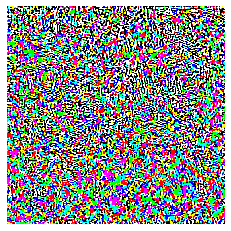

In [177]:
perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))
p_cliped = tf.clip_by_value(perturbations, 0, 1)

p_cliped_val = sess.run(p_cliped, {input_image_placeholder: preprocessed_img})
plt.figure()
plt.imshow(p_cliped_val[0])
plt.gca().axis('off')
plt.show()

## Fool the AI system

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network, however, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [178]:
def display_images(image, description):
    rev_image = reverse_preprocess(image)
    adv_img, raw_adv_img = sess.run([image, rev_image], {input_image_placeholder: preprocessed_img})
    img_probs = sess.run(pretrained_model, {input_image_placeholder: adv_img})
    top5 = get_imagenet_label(img_probs)
    top5 = list(reversed(top5))
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(raw_adv_img[0])
    plt.title(description)
    plt.gca().axis('off')
    plt.subplot(122)
    tick_names = [x[1] for x in top5]
    probs = [x[2] for x in top5]
    plt.barh(tick_names, probs)
    plt.yticks(rotation=25)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    plt.show()

**TASK 2:** Generate adverse image using different values for $\epsilon$:

- adv_x = input_image + $\epsilon$ * perturbations


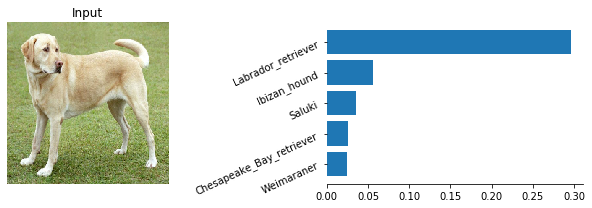

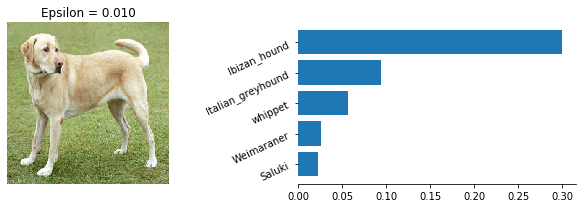

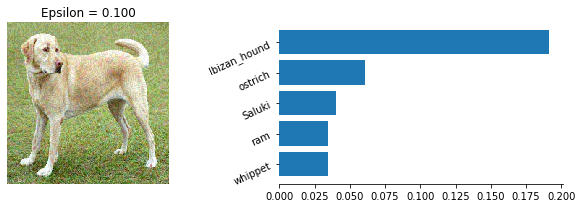

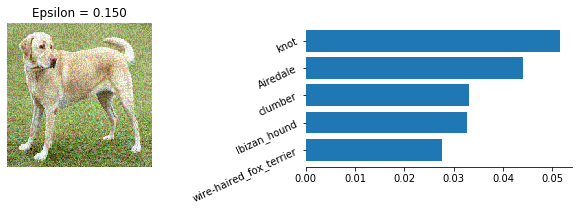

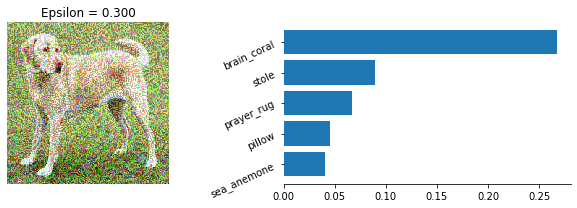

In [179]:
epsilons = [0, 0.01, 0.1, 0.15, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    ## START YOU CODE HERE
    adv_x = input_image + (eps * perturbations)
    ## End
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])




**TASK 3: What do you abserve?**

***

At lower values of Epsilon (the multiplier of our perturbations/adversarial pattern), we see very minimal *visual* change our our original image.  At only .01, we already see the trained model predicting that the image is no longer a labrador, but instead another dog breed.

At eps = 0.1, we see that it still registers as a dog breed, but other images (non-dog) are appearing with lower probability scores in the list.  At this time, we visually notice noise appearing.

At eps = 0.15 we see that the model now predicts the image is a knot, and no longer a dog.

At eps = 0.3, we don't even see a dog listed in the top 5 most probable matches.  While we see considerable noise within the image, we *as humans* can obviously see a labrador dog in the picture.




***

#  Part 2

Here, you are required to process adversarial attacks using FGSM for a small subset of [ImageNet Dataset](http://www.image-net.org/). We prepared 100 images from different categories (in `./input_dir/`), and the labels are encoded in `./input_dir/clean_image.list`.

For evaluation, each adversarial image generated by the attack model will be fed to an evaluation model, and we will calculate the successful rate of adversarial attacks. **The adversarial images that can fool the evaluation model with $\epsilon$ = 0.01 will be considered as a success**.



**Task 4: Goal**

***

With the previous FGSM example, you are required to implement an FGSM attack against all examples and calculate the success rate. Also, display the original image with the attacked image as well as the predicted class for each image.


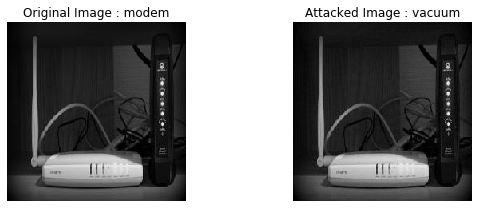

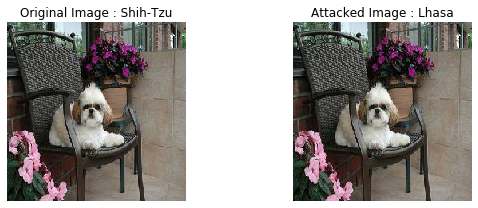

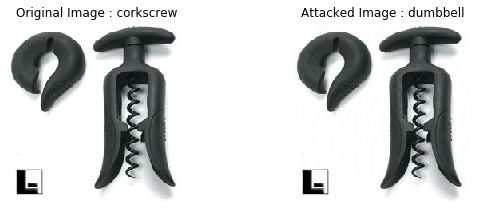

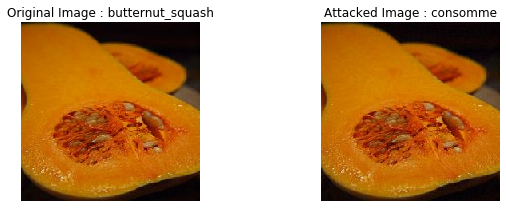

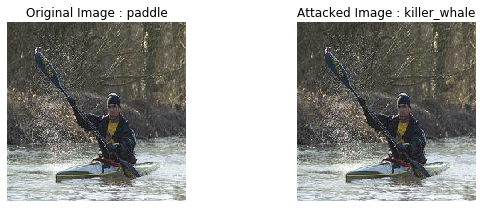

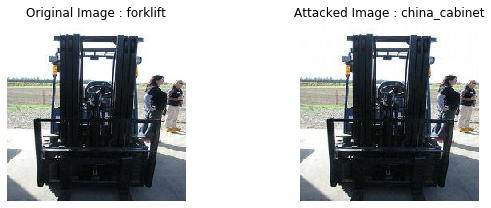

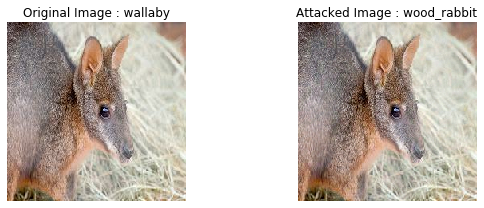

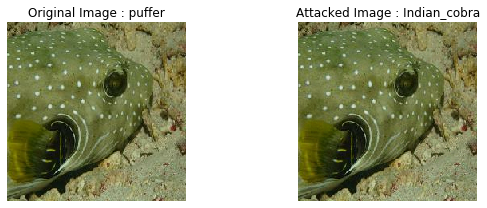

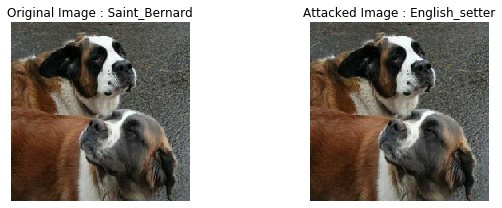

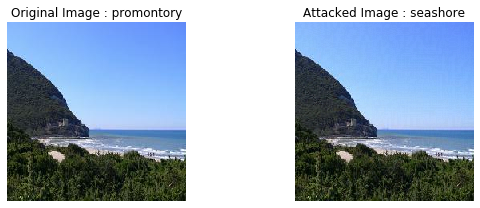

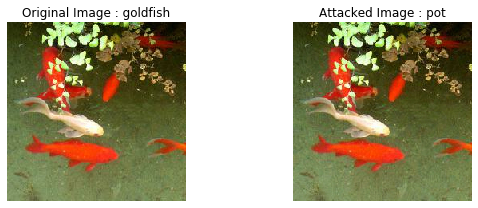

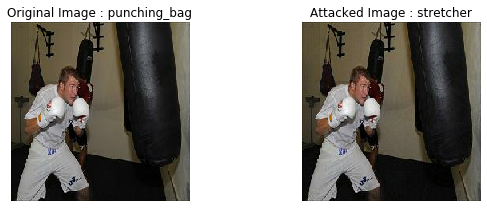

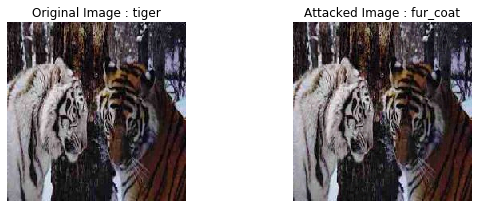

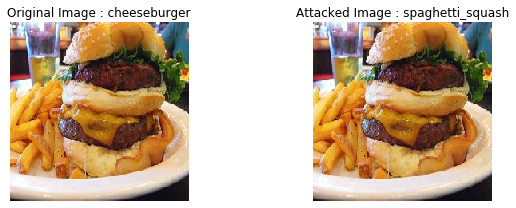

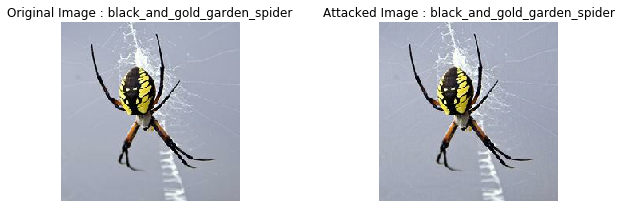

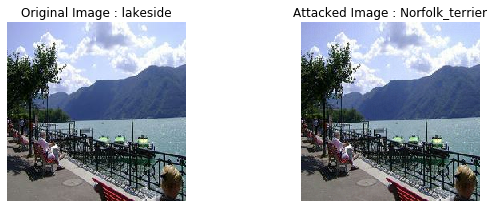

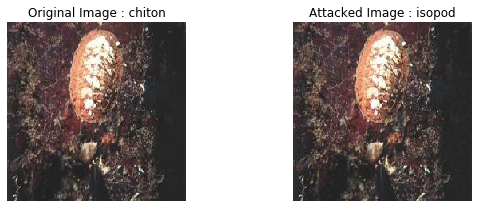

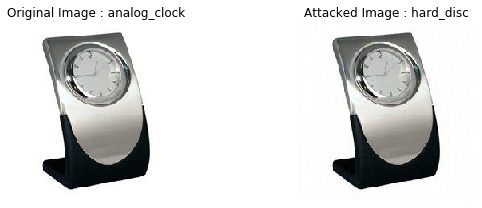

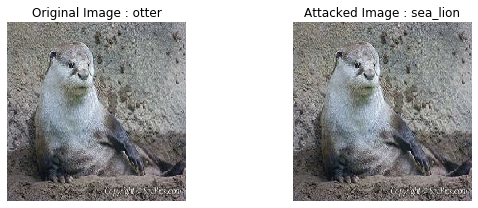

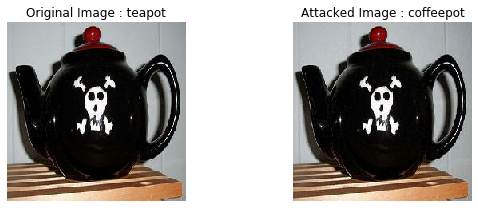

Original Image : violin    Attacked Image : revolver
Original Image : wall_clock    Attacked Image : vase
Original Image : amphibian    Attacked Image : lakeside
Original Image : hare    Attacked Image : Australian_terrier
Original Image : wreck    Attacked Image : briard
Original Image : cup    Attacked Image : barrel
Original Image : dishwasher    Attacked Image : solar_dish
Original Image : Sealyham_terrier    Attacked Image : English_setter
Original Image : rain_barrel    Attacked Image : dam
Original Image : jackfruit    Attacked Image : hen-of-the-woods
Original Image : football_helmet    Attacked Image : bearskin
Original Image : guacamole    Attacked Image : head_cabbage
Original Image : steel_drum    Attacked Image : mortar
Original Image : wooden_spoon    Attacked Image : carpenter's_kit
Original Image : digital_watch    Attacked Image : buckle
Original Image : guillotine    Attacked Image : refrigerator
Original Image : hand-held_computer    Attacked Image : space_bar
Origin

In [184]:
import os
import pandas as pd

directory_list = os.listdir(path='./input_dir/')
directory_list.remove("clean_image.list")

#Labels is not important to this task, as imagenet labels are based on filename.
labels = pd.read_csv(r'./input_dir/clean_image.list',header=None,sep=' ')

success_array = []

for i in range(len(directory_list)):

    #Load image from file
    image_raw = tf.io.read_file(f"./input_dir/{directory_list[i]}")
    image = tf.image.decode_jpeg(image_raw)
    
    #Prepare image for processing 
    input_image = preprocess(image)
    reversed_image = reverse_preprocess(input_image)
    
    #Run image against our model to see what it thinks it is
    # This is NOT required, but will confirm that unaltered images result in correct matches
    preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
    image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})
    
    #Set epsilon to our target value
    epsilon = 0.01
    
    #Recreate the perturbation 
    perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))

    #Calculate the adversarial image
    adv_image = input_image + (epsilon * perturbations)
    adv_image = tf.clip_by_value(adv_image, -1, 1)

    #Re-run the model against our adversarial image
    rev_image = reverse_preprocess(adv_image)
    adv_img, raw_adv_img = sess.run([adv_image, rev_image], {input_image_placeholder: preprocessed_img})
    img_probs = sess.run([pretrained_model], {input_image_placeholder: adv_img})

    #Decode results
    result = get_imagenet_label(image_probs[0])
    result_adv = get_imagenet_label(img_probs[0])

    #There are two ways we can check results
    # Either - we check result of adversary match vs original match
    # OR - we check result of adversary against the file name (this way)
    if (result_adv[0][0] != directory_list[i][:-5]):
        success_array.append(1)
    else:
        success_array.append(0)
    
    #Print original image and attacked image (only printing 20 pictures to save space)
    if (i < 20):
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        plt.imshow(reversed_img[0])
        plt.title(f"Original Image : {result[0][1]}")
        plt.gca().axis('off')
        plt.subplot(122)
        plt.imshow(raw_adv_img[0])
        plt.title(f"Attacked Image : {result_adv[0][1]}")
        plt.gca().axis('off')
        plt.tight_layout()
        plt.show()
    else:
        #Print just the results
        print(f"Original Image : {result[0][1]}    Attacked Image : {result_adv[0][1]}")
print(f"Overall success of attack was {(sum(success_array)/len(success_array))*100:.2f}% (from {len(success_array)} images)")    


***

# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways attack and fool an AI system. Here are the main points you should remember:

- It is very easy to fool a computer vision system if you know the model and its parameters.
- When designing an AI system, you need to think of adverse attacks againsts your system.

Congratulations on finishing this notebook! 

